In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
data=pd.read_csv("../levelups_panel_20240717.csv", encoding="utf-8")

In [47]:
# level_to 컬럼의 값이 100을 넘는 행 제거
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data['binge'] = (data['first_session_level'] >= 50).astype(int)
# 각 player_slug별로 비율 계산
data['prev_interval'] = data.groupby('player_slug')['interval'].shift(1)
data['interval_ratio'] = data.apply(lambda row: row['interval'] / (row['prev_interval'] if pd.notnull(row['prev_interval']) else row['interval']), axis=1)
#data.to_csv("LV100.csv",index=False, encoding="utf-8")


In [48]:
#Remove odd ratio data
data.loc[data['interval_ratio'] > 50, 'interval'] = np.nan

data_ratio_term = data[['player_slug','binge', 'level_to', 'interval']]
threshold_df = pd.DataFrame(columns=['Column', 'Threshold'])

# 데이터 피벗
pivot_data_ratio = data_ratio_term.pivot_table(index='player_slug', columns='level_to', values='interval', aggfunc='mean')
binge_series = data.drop_duplicates('player_slug').set_index('player_slug')['binge']
pivot_data_ratio = pivot_data_ratio.join(binge_series)
#Remove top 1% value of the interval
columns_to_exclude = ['binge']
for column in pivot_data_ratio.columns:
    # NaN 값을 제외하고 상위 99% 값 계산
    threshold = pivot_data_ratio[column].dropna().quantile(0.975)
    
    pivot_data_ratio.loc[pivot_data_ratio[column] > threshold, column] = np.nan
    # 컬럼명과 threshold 값을 데이터프레임에 추가
    temp_df = pd.DataFrame({'Column': [column], 'Threshold': [threshold]})
    
    # 기존 데이터프레임과 임시 데이터프레임을 결합
    threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)

pivot_data_reset = pivot_data_ratio.reset_index().melt(id_vars=['player_slug', 'binge'], var_name='level_to', value_name='interval')


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_19328\1380875362.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_df = pd.concat([threshold_df, temp_df], ignore_index=True)


In [49]:
pivot_data_reset

,player_slug,binge,level_to,interval
0,2021-11-01T08:32:01.518Z,1.0,2,NaN
1,2021-11-01T10:41:53.949Z,1.0,2,0.020556
2,2021-11-01T14:12:34.729Z,1.0,2,0.015833
3,2021-11-01T15:01:02.831Z,0.0,2,0.007778
4,2021-11-01T15:10:02.121Z,0.0,2,0.006944
...,...,...,...,...
720616,2022-03-28T00:01:33.666Z,1.0,100,0.600833
720617,2022-03-28T07:44:40.201Z,1.0,100,0.067500
720618,2022-03-28T11:06:23.113Z,0.0,100,0.149722
720619,2022-03-29T09:29:33.653Z,0.0,100,0.102778


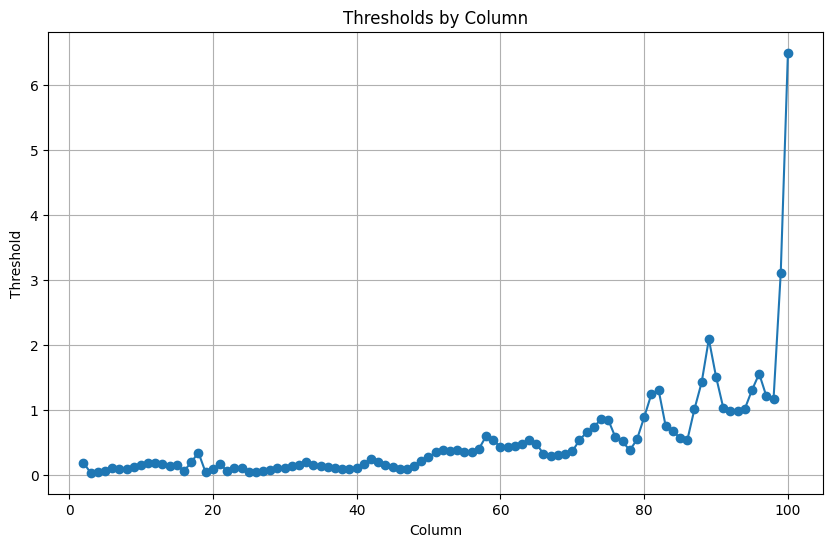

In [50]:
# 마지막 행 드랍
df = threshold_df.drop(threshold_df.index[-1])

# 플롯 그리기
plt.figure(figsize=(10, 6))
plt.plot(df['Column'], df['Threshold'], marker='o')
plt.xlabel('Column')
plt.ylabel('Threshold')
plt.title('Thresholds by Column')
plt.grid(True)
plt.show()

In [51]:
pivot_data_ratio.to_csv('remove_outlier_0919.csv',encoding='utf-8')

In [52]:
import numpy as np
import pandas as pd
import cvxpy as cp
from tqdm import tqdm
#pivot_data_ratio =pd.read_csv("Before_Synthetic.csv",encoding='utf-8')
pivot_data_ratio =pd.read_csv("remove_outlier_0919.csv",encoding='utf-8')
origin_data=pd.read_csv("../levelups_panel_20240717.csv",encoding='utf-8')

In [53]:
# other_data를 before_synthetic에 병합
for i, row in tqdm(origin_data.iterrows(), total=origin_data.shape[0]):
    player = row['player_slug']
    level_to = str(row['level_to'])
    if player in pivot_data_ratio['player_slug'].values and level_to in pivot_data_ratio.columns:
        origin_data.loc[i, 'interval'] = pivot_data_ratio.loc[pivot_data_ratio['player_slug'] == player, level_to].values[0]


100%|██████████| 2466997/2466997 [29:16<00:00, 1404.68it/s]


In [54]:
origin_data.to_csv("levelups_panel_20240919_new.csv", index=False,encoding="utf-8")
origin_data.to_csv("levelups_panel_20240919_newcp949.csv", index=False,encoding="cp949")

In [55]:
data=pd.read_csv("levelups_panel_20240919_new.csv",encoding="utf-8")

In [37]:
check=data[data['player_slug']=='2022-03-09T10:40:35.069Z']
check[['level_from','level_to','interval','interval_ratio']].tail(20)

,level_from,level_to,interval,interval_ratio
2092979,80,81,0.036111,0.948905
2092980,81,82,0.042778,1.184615
2092981,82,83,0.030000,0.701299
2092982,83,84,0.025556,0.851852
2092983,84,85,0.014722,0.576087
2092984,85,86,0.003889,0.264151
2092985,86,87,0.039444,10.142857
2092986,87,88,0.035833,0.908451
2092987,88,89,0.037778,1.054264
2092988,89,90,0.039167,1.036765
